In [1]:
import scqubits as scq
import numpy as np
from systemclass import SNAIL
def sort_eigenpairs(eigenvalues, eigenvectors):
    n = eigenvectors.shape[0]
    sorted_indices = []

    for i in range(n):
        max_abs_vals = np.abs(eigenvectors[i, :])
        max_index = np.argmax(max_abs_vals)
        while max_index in sorted_indices:
            max_abs_vals[max_index] = -np.inf
            max_index = np.argmax(max_abs_vals)
        sorted_indices.append(max_index)

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    return sorted_eigenvalues, sorted_eigenvectors
d1=d2=2
fluxonium1 = scq.Fluxonium(
    EJ=4.6,
    EC=0.9,
    EL=1.5,
    cutoff = 110,
    flux = 0.5,
    truncated_dim=d1
)
fluxonium2 = scq.Fluxonium(
    EJ=5.5,
    EC=0.9,
    EL=1.5,
    cutoff = 110,
    flux = 0.5,
    truncated_dim=d2
)

def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
dims = 8
sd = creation(dims)
s = annihilation(dims)
omega_s = 7*2*np.pi
g3 = 0.1*2*np.pi
Hs = omega_s*sd@s + g3*(s+sd)@(s+sd)@(s+sd)
Is = 1*np.identity(dims)

charge_op = -1j*(s-sd)

In [2]:
phi1 = fluxonium1.phi_operator(energy_esys=True)
phi2 = fluxonium2.phi_operator(energy_esys=True)

H1 = fluxonium1.hamiltonian(energy_esys=True)*2*np.pi
H2 = fluxonium2.hamiltonian(energy_esys=True)*2*np.pi

H1 = (H1-np.identity(d1)*H1[0,0])
H2 = (H2-np.identity(d2)*H2[0,0])

In [3]:
H1/2/np.pi

array([[0.       , 0.       ],
       [0.       , 0.6928183]])

In [4]:
H2/2/np.pi

array([[0.        , 0.        ],
       [0.        , 0.43349013]])

In [5]:
ff1 = H1[1][1]
ff2 = H2[1][1]

In [6]:


If1 = np.identity(d1)
If2 = np.identity(d2)
Is = np.identity(dims)

Hs = np.kron(np.kron(Hs,If1),If2)
H1 = np.kron(np.kron(Is,H1),If2)
H2 = np.kron(np.kron(Is,If1),H2)

g_int1 = 0.3*2*np.pi
g_int2 = 0.3*2*np.pi
H_int1 = g_int1 * np.kron(np.kron(charge_op,phi1),If2) 
H_int2 = g_int2 * np.kron(np.kron(charge_op,If1),phi2)
hc =  np.kron(np.kron(charge_op,If1),If2)

In [7]:
H = Hs + H1 + H2 + H_int1 + H_int2

In [8]:
np.diag(H)/2/np.pi

array([ 0.        +0.j,  0.43349013+0.j,  0.6928183 +0.j,  1.12630843+0.j,
        7.        +0.j,  7.43349013+0.j,  7.6928183 +0.j,  8.12630843+0.j,
       14.        +0.j, 14.43349013+0.j, 14.6928183 +0.j, 15.12630843+0.j,
       21.        +0.j, 21.43349013+0.j, 21.6928183 +0.j, 22.12630843+0.j,
       28.        +0.j, 28.43349013+0.j, 28.6928183 +0.j, 29.12630843+0.j,
       35.        +0.j, 35.43349013+0.j, 35.6928183 +0.j, 36.12630843+0.j,
       42.        +0.j, 42.43349013+0.j, 42.6928183 +0.j, 43.12630843+0.j,
       49.        +0.j, 49.43349013+0.j, 49.6928183 +0.j, 50.12630843+0.j])

In [9]:
energy0,U = np.linalg.eigh(H)
(energy0 - energy0[0])/2/np.pi

array([ 0.        ,  0.39815095,  0.73095266,  1.12900421,  6.92757045,
        7.31114292,  7.64023412,  8.02350851, 13.76177295, 14.13073987,
       14.45606397, 14.82453539, 20.50861202, 20.86361601, 21.18442986,
       21.53876886, 27.25985636, 27.60387868, 27.91828283, 28.26157894,
       34.36391167, 34.71156824, 35.00590207, 35.35317363, 43.04132776,
       43.39783914, 43.68298887, 44.04015312, 51.22719624, 51.42790313,
       52.52619204, 52.72759587])

In [10]:
(energy0[3]-energy0[2]-energy0[1])/2/np.pi

0.12357299041029648

In [11]:
energy0,U = np.linalg.eigh(H)
energy0,U = sort_eigenpairs(energy0, U)
energy0 = energy0 - energy0[0]
Ud = U.transpose().conjugate()
H = np.diag(energy0)
hc = Ud@hc@U

In [12]:
np.abs(hc[:4,:4])

array([[2.89060235e-15, 2.46927008e-01, 1.05469472e-01, 7.69342515e-06],
       [2.46927008e-01, 3.19360790e-16, 2.98538641e-06, 1.96940407e-01],
       [1.05469472e-01, 2.98538641e-06, 1.32989313e-15, 1.06660390e-01],
       [7.69342515e-06, 1.96940407e-01, 1.06660390e-01, 2.74940222e-15]])

In [13]:
def gaussian_ramp(t0,t1, amplitude):
    """
    Creates a time-dependent function using a Gaussian function that starts near zero,
    peaks at 'amplitude' at time 't0', and remains constant at 'amplitude' for t > t0.

    Args:
    t0 (float): The time at which the function peaks at the amplitude.
    amplitude (float): The maximum amplitude of the Gaussian peak.

    Returns:
    function: A function of time 't' that implements the desired behavior.
    """
    # Define the standard deviation such that the peak is sharp at t0
    sigma = t0 / 3  # Adjust sigma to make the function start close to zero at t=0
    
    offset = amplitude * np.exp(-((0 - t0)**2) / (2 * sigma**2))
    
    # Define the function using a closure to encapsulate the parameters
    def time_dependent_function(t):
        if t <= t0:
            # Gaussian function for ramp up
            return amplitude * np.exp(-((t - t0)**2) / (2 * sigma**2)) - offset
        elif t <= t1:
            # Constant amplitude between t0 and t1
            return amplitude - offset
        else:
            # Symmetric Gaussian function for ramp down
            return amplitude * np.exp(-((t - t1)**2) / (2 * sigma**2)) - offset

    return time_dependent_function

In [14]:
index1 = np.argmin(np.abs(energy0 - ff1 * np.ones(len(energy0))))
index2 = np.argmin(np.abs(energy0 - ff2 * np.ones(len(energy0))))
index3 = np.argmin(np.abs(energy0 - (ff2+ff1) * np.ones(len(energy0))))
# index3 = 3


In [15]:
ff2/2/np.pi

0.43349013312855583

In [16]:
import qutip as qt
total_dim = dims*d1*d2
H0=qt.Qobj(H)
hc =qt.Qobj(hc)

In [17]:
(H0/2/np.pi)[3][3]-(H0/2/np.pi)[0][0]

(1.129004212116474+0j)

In [18]:
(H0/2/np.pi)

Quantum object: dims=[[32], [32]], shape=(32, 32), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.39815095  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.73095266 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 51.42790313  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         52.52619204
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  52.72759587]]

In [28]:
sigmax = qt.sigmax()
sigmax_tensor_sigmax = qt.tensor(sigmax, sigmax)

# Step 2: Convert hc to a NumPy array
hc_array = hc.full()
fac = 1e-1
# Step 3: Replace the submatrix
# hc_array[0:4, 0:4] =sigmax_tensor_sigmax.full()*1e-3
hc_array[0:4, 0:4] = np.array([[2.02895893e-15, 2.47357762e-01*fac, 1.06584190e-01*fac, 1.08008876e-04],
       [2.47357762e-01*fac, 1.46932733e-15, 2.08193097e-04, 2.01892393e-01*fac],
       [1.06584190e-01*fac, 2.08193097e-04, 4.75542472e-16, 1.06133882e-01*fac],
       [1.08008876e-04, 2.01892393e-01*fac, 1.06133882e-01*fac, 2.15797206e-16]])

# Step 4: Convert the modified array back to a Qobj
# Make sure to use the same dimensions as the original hc
new_hc = qt.Qobj(hc_array, dims=hc.dims)
hc = new_hc

In [29]:
psi0 = qt.basis(total_dim, 0)
PP0 = qt.basis(total_dim, 0)*qt.basis(total_dim, 0).dag()
PP1 = qt.basis(total_dim, index1)*qt.basis(total_dim, index1).dag()
PP2 = qt.basis(total_dim, index2)*qt.basis(total_dim, index2).dag()
PP3 = qt.basis(total_dim, index3)*qt.basis(total_dim, index3).dag()
duration = 4000
drive_func = gaussian_ramp(5,duration, 1*2*np.pi)
omega = 1.1277*2*np.pi
args = {'w': omega}
tlist = np.linspace(0, duration+5, 10000)  # Cover ten periods
H = [H0, [hc, lambda t, args: drive_func(t)*np.cos(args['w']*t)]]
result = qt.sesolve(H, psi0, tlist, args=args)
exp_P0 = np.array([qt.expect(PP0, state) for state in result.states])
exp_P1 = np.array([qt.expect(PP1, state) for state in result.states])
exp_P2 = np.array([qt.expect(PP2, state) for state in result.states])
exp_P3 = np.array([qt.expect(PP3, state) for state in result.states])

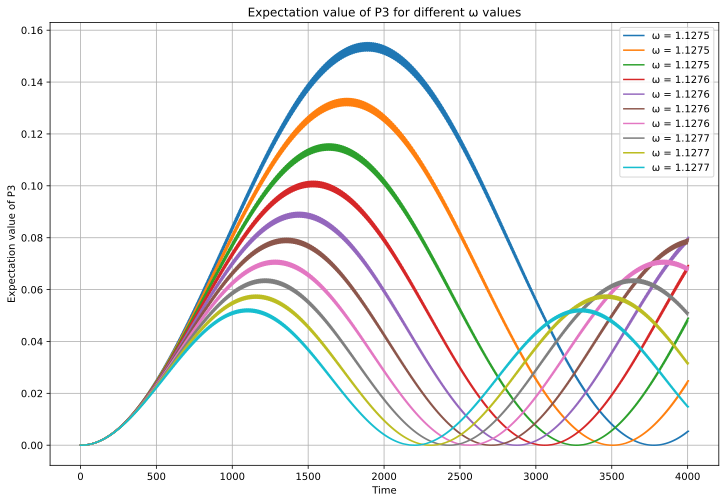

In [30]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Assuming all necessary functions and variables are defined earlier

psi0 = qt.basis(total_dim, 0)
PP0 = qt.basis(total_dim, 0)*qt.basis(total_dim, 0).dag()
PP1 = qt.basis(total_dim, index1)*qt.basis(total_dim, index1).dag()
PP2 = qt.basis(total_dim, index2)*qt.basis(total_dim, index2).dag()
PP3 = qt.basis(total_dim, index3)*qt.basis(total_dim, index3).dag()
duration = 4000
drive_func = gaussian_ramp(5, duration, 1*2*np.pi)

omega_range = np.linspace(1.1275, 1.1277, 10) * 2 * np.pi  # 20 points between 1.276 and 1.28
tlist = np.linspace(0, duration+5, 10000)  # Cover ten periods

exp_P3_list = []

for omega in omega_range:
    args = {'w': omega}
    H = [H0, [hc, lambda t, args: drive_func(t)*np.cos(args['w']*t)]]
    result = qt.sesolve(H, psi0, tlist, args=args)
    exp_P3 = np.array([qt.expect(PP3, state) for state in result.states])
    exp_P3_list.append(exp_P3)

# Plotting
plt.figure(figsize=(12, 8))
for i, omega in enumerate(omega_range):
    plt.plot(tlist, exp_P3_list[i], label=f'ω = {omega/(2*np.pi):.4f}')

plt.xlabel('Time')
plt.ylabel('Expectation value of P3')
plt.title('Expectation value of P3 for different ω values')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
amplitude = []
for t in tlist:
    amplitude.append(drive_func(t))

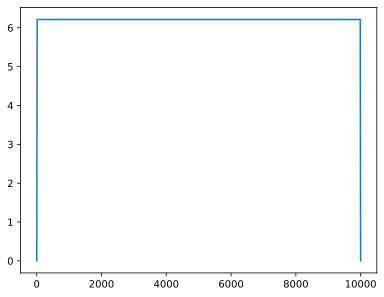

In [22]:
from matplotlib import pyplot as plt
plt.plot(amplitude)

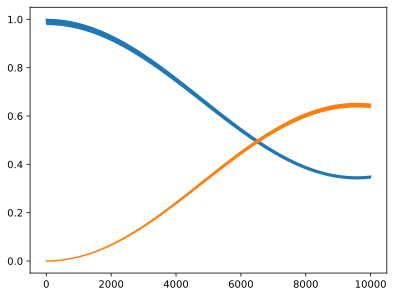

In [23]:
from matplotlib import pyplot as plt
plt.plot(exp_P0)
# plt.plot(exp_P1)
# plt.plot(exp_P2)
plt.plot(exp_P3)

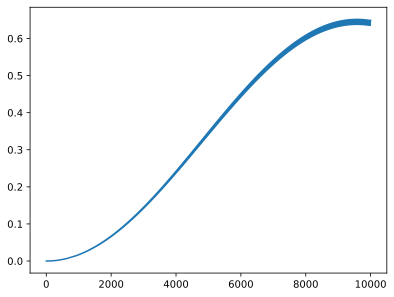

In [24]:
# plt.plot(exp_P1)
# plt.plot(exp_P2)
plt.plot(exp_P3)